### Combined Model V1

In [1]:
import sys, json, os, ast
import copy
import numpy as np
import pandas as pd
from smart_open import open
from tqdm import tqdm
import pickle as pkl
import lightgbm as lgb

sys.path.insert(1, "../..")
from src.logger import make_logger
from src.dataloader import TabularDataloader
from src.Trainer import LGBMTrainer, TFTrainer
from src.preprocess import Preprocess

from rdsutils.feature_selection import mrmr
from rdsutils.woe import WOE_Transform
from _utils.feature_selection import feature_selection as fs
from _utils.performance_eval import performance_eval_v3 as p_eval
from rdsutils.feature_selection import FeatureSelector

# new modules
from _utils.sample_weights import get_sample_weight

%load_ext autoreload
%autoreload 2

### Load Data and Preprocess

In [2]:
target = 'target_v1'
target_indeterminate = 'indeterminate_v1'
weight = "weight"
seed = 42

model_params_path = "./artifacts/models/model_params.json"
model_dir = "./artifacts/models"

# load some feature sets
with open("config.json", "r") as f:
    config = json.load(f)

with open(model_params_path, "r") as f:
    model_params = json.load(f)

with open("./artifacts/models/lightgbm-dev1_v1_benchmark_mc.pkl", "rb") as f:
    model_dev1_v1 = pkl.load(f)
    
with open("./artifacts/models/lightgbm-dev2_v1_benchmark_mc.pkl", "rb") as f:
    model_dev2_v1 = pkl.load(f)
    
with open("./artifacts/models/lightgbm-dev2_v2_benchmark_mc.pkl", "rb") as f:
    model_dev2_v2 = pkl.load(f)
    
# expn data dict
exp_dict = pd.read_csv(config["meta"]["exp_dict_path"])

# fsel classes
# rankings = pd.read_csv("./artifacts/dev2_fsel_v1/ranking.csv", index_col=0)
# rankings["mean"] = rankings.mean(axis=1)
# rankings.sort_values("mean", inplace=True)
    
benchmark_fts = model_params["combined_v1_benchmark"]["features"]
gen3_features = config["data_columns"]["gen3_features"]

In [3]:
# meta data columns
benchmarks = ["gen3_score", "applicant_fico_score"]
meta_cols = [target, target_indeterminate, "ri_source",
                      "weight_ri_v1", "weight_cob"]
features = list(set(gen3_features +
                    model_dev1_v1.feature_name_ + 
                    model_dev2_v1.feature_name_ + 
                    model_dev2_v2.feature_name_ + 
                    benchmark_fts))
cols = benchmarks + meta_cols + features

train_df1 = pd.read_parquet(config["data"]["clean"]["all_features_dev1"], columns=cols)
train_df2 = pd.read_parquet(config["data"]["clean"]["all_features_dev2"], columns=cols)
train_df1["period"] = 1
train_df2["period"] = 2

test_df1 = pd.read_parquet(config["data"]["clean"]["all_features_oot1"], columns=cols)
test_df2 = pd.read_parquet(config["data"]["clean"]["all_features_oot2"], columns=cols)
test_df1["period"] = 1
test_df2["period"] = 2

train_df = pd.concat([train_df1, train_df2], axis=0)
test_df = pd.concat([test_df1, test_df2], axis=0)
train_df.shape, test_df.shape

((4404764, 100), (1150725, 100))

In [4]:
%%time
from src.preprocess import Preprocess

col = "ri_source"
weights = {"booked": 1,
           "proxy": 1,
           "others": 0.25}

pp = Preprocess(exp_dict)

train_df["weight_eval"] = train_df["weight_cob"] * train_df["weight_ri_v1"]
test_df["weight_eval"] = test_df["weight_cob"] * test_df["weight_ri_v1"]

train_df = pp.transform(train_df, features, weights, 
                        drop_indeterminate=target_indeterminate, 
                        existing_weights_col="weight_eval")
test_df = pp.transform(test_df, features, weights,
                       drop_indeterminate=None,
                       existing_weights_col="weight_eval")


100%|██████████| 92/92 [01:00<00:00,  1.53it/s]



        added columns:
            weight: training sample_weight scaled using provided weights by ri_source
                weight_eval * weight_sample
        
dropping indeterminate col: indeterminate_v1


100%|██████████| 92/92 [00:15<00:00,  5.95it/s]



        added columns:
            weight: training sample_weight scaled using provided weights by ri_source
                weight_eval * weight_sample
        
CPU times: user 44.3 s, sys: 36.8 s, total: 1min 21s
Wall time: 1min 20s


In [5]:
print("----- weights for model fitting -----")
display(train_df[["weight", "ri_source"]].groupby("ri_source")["weight"].sum())
display(test_df[["weight", "ri_source"]].groupby("ri_source")["weight"].sum())

print("----- weights for evaluations -----")
display(train_df[["weight_eval", "ri_source"]].groupby("ri_source")["weight_eval"].sum())
display(test_df[["weight_eval", "ri_source"]].groupby("ri_source")["weight_eval"].sum())

----- weights for model fitting -----


ri_source
booked    261805.000
others    444556.875
proxy     376205.000
Name: weight, dtype: float64

ri_source
booked     68127.50
others    115120.75
proxy     105072.50
Name: weight, dtype: float64

----- weights for evaluations -----


ri_source
booked     261805.0
others    1778227.5
proxy      376205.0
Name: weight_eval, dtype: float64

ri_source
booked     68127.5
others    460483.0
proxy     105072.5
Name: weight_eval, dtype: float64

### Train Models

In [16]:
# without indicator

for mname in tqdm(model_params):
    if "combined" in mname:
        params_ = copy.deepcopy(model_params[mname]["params"])
        fts_ = copy.deepcopy(model_params[mname]["features"])
        mtype = copy.deepcopy(model_params[mname]["model_type"])

        lgbm_ = lgb.LGBMClassifier(**params_)
        trainer = LGBMTrainer()
        trainer.train(lgbm_, 
                      train_df,
                      features = fts_,
                      target_col = target,
                      sample_weight = train_df[weight]
                     )
        trainer.save_model(os.path.join(model_dir, f"{mtype}-{mname}.pkl"))

100%|██████████| 10/10 [01:23<00:00,  8.38s/it]


In [18]:
# with indicator
for mname in tqdm(model_params):
    if "combined" in mname:
        params_ = copy.deepcopy(model_params[mname]["params"])
        fts_ = copy.deepcopy(model_params[mname]["features"])
        mtype = copy.deepcopy(model_params[mname]["model_type"])

        fts_.append("period")
        params_["categorical_feature"] = [len(fts_)]
        if "monotone_constraints" in params_:
            params_["monotone_constraints"].append(0)
            
        lgbm_ = lgb.LGBMClassifier(**params_)
        trainer = LGBMTrainer()
        trainer.train(lgbm_, 
                      train_df,
                      features = fts_,
                      target_col = target,
                      sample_weight = train_df[weight]
                     )
        trainer.save_model(os.path.join(model_dir, f"{mtype}-{mname}-w-period-ind.pkl"))

100%|██████████| 10/10 [01:21<00:00,  8.14s/it]


### Model Eval

['pred_combined_v1_benchmark',
 'pred_combined_v1_benchmark_mc',
 'pred_combined_v1_benchmark_mc_wperiod',
 'pred_combined_v1_benchmark_wperiod',
 'pred_combined_w_ind_max',
 'pred_combined_w_ind_mean',
 'pred_combined_w_ind_min',
 'pred_fico',
 'pred_gen3']

In [1]:
models = os.listdir(model_dir)
dev2_models = filter(lambda mname: "combined_v1" in mname, models)
pred_cols = []

for mname in tqdm(dev2_models):
    mpath = os.path.join(model_dir, mname)
    with open(mpath, "rb") as f:
        model = pkl.load(f)
    
    pred_col = mname.split(".")[0]
    pred_col = pred_col.split("-")[1] # remove lightgbm- and .pkl
    if "period" in mname:
        pred_col += "_wperiod"
    test_df[f"pred_{pred_col}"] = model.predict_proba(test_df[model.feature_name_])[:,1]
    pred_cols.append(f"pred_{pred_col}")

NameError: name 'os' is not defined

In [ ]:
# for each record, make pred with period = 0 and 1
mname = "lightgbm-combined_v1_benchmark_mc-w-period-ind.pkl"
mpath = os.path.join(model_dir, mname)
with open(mpath, "rb") as f:
    model = pkl.load(f)

class CombinedModel(lgb.LGBMClassifier):
    
    def __init__(self, model):
        self.model = model
        super().__init__()
        
    
    def predict_proba(self, df, method="mean"):
        df_ = df.copy(deep=True)
        df_["period"] = 1
        p0 = self.model.predict_proba(df_[self.model.feature_name_])[:,1]
        df_["period"] = 2
        p1 = self.model.predict_proba(df_[self.model.feature_name_])[:,1]
        
        preds = np.stack([p0, p1])
        return getattr(preds, method)(axis=0)
            

In [ ]:
test_df["pred_gen3"] = -test_df["gen3_score"]  # reverse dir of gen3 score
test_df["pred_fico"] = -test_df["applicant_fico_score"]

In [ ]:
fts_ = [ft for ft in model.feature_name_ if f != "period"]
model_ = CombinedModel(model)
test_df["pred_combined_w_ind_max"] = model_.predict_proba(test_df[fts_], "max")
test_df["pred_combined_w_ind_min"] = model_.predict_proba(test_df[fts_], "min")
test_df["pred_combined_w_ind_mean"] = model_.predict_proba(test_df[fts_], "mean")


In [ ]:
pred_cols = ['pred_dev1_v1_benchmark_mc',
             'pred_dev2_v1_benchmark_mc',
             'pred_combined_v1_benchmark_mc',
             'pred_combined_w_ind_mean',
             'pred_fico',
             'pred_gen3']

print(model_dev1_v1.feature_name_, model_dev2_v1.feature_name_)
test_df["pred_dev1_v1_benchmark_mc"] = model_dev1_v1.predict_proba(test_df[model_dev1_v1.feature_name_])[:,1]
test_df["pred_dev2_v1_benchmark_mc"] = model_dev2_v1.predict_proba(test_df[model_dev2_v1.feature_name_])[:,1]

In [117]:
from rdsutils.metrics import get_pred_reports

pred_cols = ['pred_dev1_v1_benchmark_mc',
             'pred_dev2_v1_benchmark_mc',
             'pred_combined_v1_benchmark_mc',
             'pred_fico',
             'pred_gen3']

perf = get_pred_reports(test_df, target, pred_cols, sample_weight_col="weight_eval").sort_values("ks")
perf["ks_chg"] = perf["ks"] / perf.loc["pred_gen3", "ks"]
display(perf.round(4))

,auc,ap,ks,ks_chg
pred_fico,0.7157,0.3187,31.98,0.8467
pred_gen3,0.7559,0.3504,37.77,1.0000
pred_dev2_v1_benchmark_mc,0.7670,0.3675,39.41,1.0434
pred_dev1_v1_benchmark_mc,0.7686,0.3652,39.90,1.0564
pred_combined_v1_benchmark_mc,0.7700,0.3691,39.96,1.0580


In [121]:
for p in [1, 2]:
    print(f"-------- v1 - period oot - {p} --------")
    test_df_ = test_df[(test_df.period==p)]
    print(test_df_.shape)

    perf = get_pred_reports(test_df_, target, pred_cols, 
                            sample_weight_col="weight_eval").sort_values("ks")
    perf["ks_chg"] = perf["ks"] / perf.loc["pred_gen3", "ks"]
    display(perf.round(4))

-------- v1 - period oot - 1 --------
(567316, 114)


,auc,ap,ks,ks_chg
pred_fico,0.6931,0.2980,28.94,0.8059
pred_gen3,0.7430,0.3368,35.91,1.0000
pred_dev2_v1_benchmark_mc,0.7547,0.3538,37.70,1.0498
pred_combined_v1_benchmark_mc,0.7587,0.3578,38.29,1.0663
pred_dev1_v1_benchmark_mc,0.7583,0.3577,38.32,1.0671


-------- v1 - period oot - 2 --------
(583409, 114)


,auc,ap,ks,ks_chg
pred_fico,0.7407,0.3426,35.48,0.8903
pred_gen3,0.7695,0.3658,39.85,1.0000
pred_dev2_v1_benchmark_mc,0.7798,0.3835,41.23,1.0346
pred_dev1_v1_benchmark_mc,0.7795,0.3740,41.60,1.0439
pred_combined_v1_benchmark_mc,0.7821,0.3825,41.79,1.0487


In [119]:
for p in [1, 2]:
    print(f"-------- period oot - {p} - booked --------")
    test_df_ = test_df[(test_df.period==p) & (test_df.ri_source=="booked")]
    print(test_df_.shape)

    perf = get_pred_reports(test_df_, target, pred_cols, 
                            sample_weight_col="weight_eval").sort_values("ks")
    perf["ks_chg"] = perf["ks"] / perf.loc["pred_gen3", "ks"]
    display(perf.round(4))

-------- period oot - 1 - booked --------
(38086, 114)


,auc,ap,ks,ks_chg
pred_fico,0.6257,0.0830,18.55,0.6072
pred_gen3,0.7051,0.1257,30.55,1.0000
pred_combined_v1_benchmark_mc,0.7321,0.1413,33.70,1.1031
pred_dev2_v1_benchmark_mc,0.7262,0.1380,33.77,1.1054
pred_dev1_v1_benchmark_mc,0.7313,0.1440,34.61,1.1329


-------- period oot - 2 - booked --------
(32980, 114)


,auc,ap,ks,ks_chg
pred_fico,0.5914,0.0576,13.59,0.4773
pred_gen3,0.6916,0.0958,28.47,1.0000
pred_dev2_v1_benchmark_mc,0.7216,0.1048,32.94,1.1570
pred_dev1_v1_benchmark_mc,0.7241,0.1124,33.57,1.1791
pred_combined_v1_benchmark_mc,0.7306,0.1135,35.11,1.2332


In [116]:
# transfer learning - data augmentation
train_df1.shape, train_df2.shape

((2281891, 100), (2122873, 100))

pred_combined_v1_benchmark_mc AUC:  0.76973  KS:  40.0
applicant_fico_score AUC:  0.71571  KS:  31.9
gen3_score AUC:  0.75588  KS:  37.7

Gains Table--Model:
   pct_cum_acct   #accts     min     max  target_num pct_cum_target  \
0          4.4%  28009.5  0.4823  0.9391     14380.9          15.1%   
1          8.9%  28629.0  0.3858  0.4823     11628.3          27.3%   
2         13.5%  29138.5  0.3192  0.3858      9779.0          37.6%   
3         18.2%  29604.5  0.2701  0.3192      8196.3          46.2%   
4         22.9%  29989.5  0.2312  0.2701      7119.4          53.6%   
5         27.7%  30442.0  0.2000  0.2312      6336.2          60.3%   
6         32.6%  30796.5  0.1740  0.2000      5541.5          66.1%   
7         37.5%  31303.5  0.1522  0.1740      5113.1          71.5%   
8         42.5%  31530.5  0.1334  0.1522      4511.0          76.2%   
9         47.6%  31896.0  0.1172  0.1334      3933.1          80.3%   
10        52.6%  32237.0  0.1027  0.1172      3513.7         

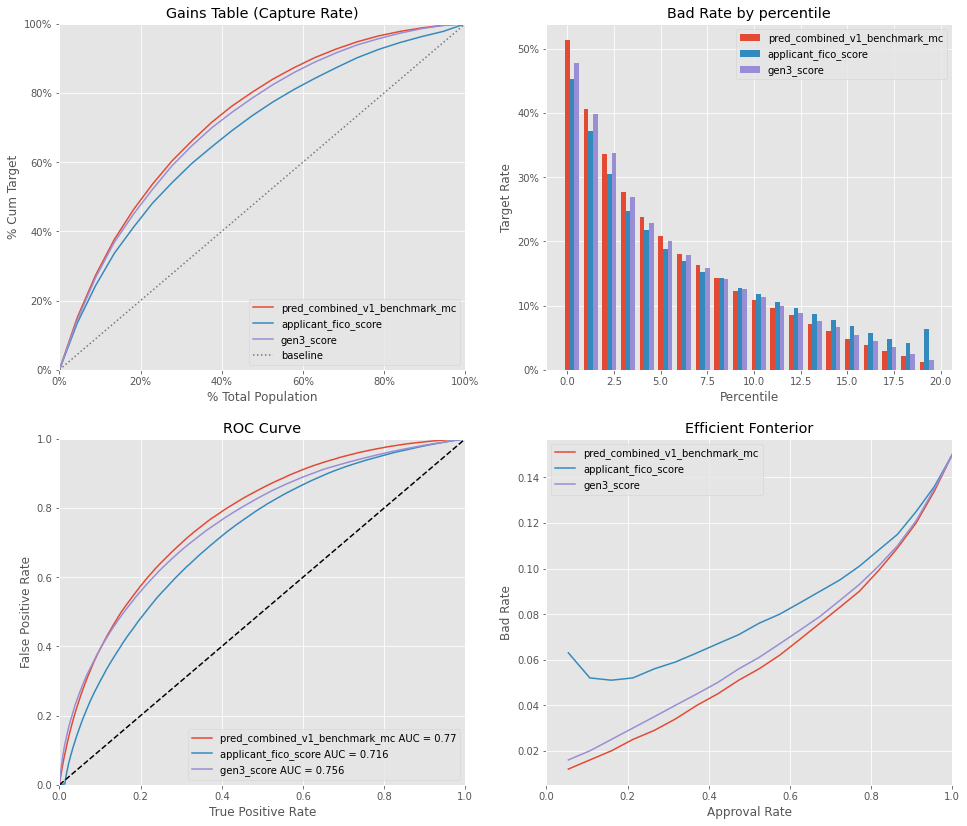

(0.7558784816612554, 37.699999999999996)

In [23]:
p_eval.model_score_eval(test_df[target],
                        test_df['pred_combined_v1_benchmark_mc'],
                        test_df['applicant_fico_score'],
                        test_df['gen3_score'],
                        Y_weight=test_df["weight_eval"],decile=20)

Text(0.5, 1.0, 'Prescreen Dev2 v1 - ROC Curve')

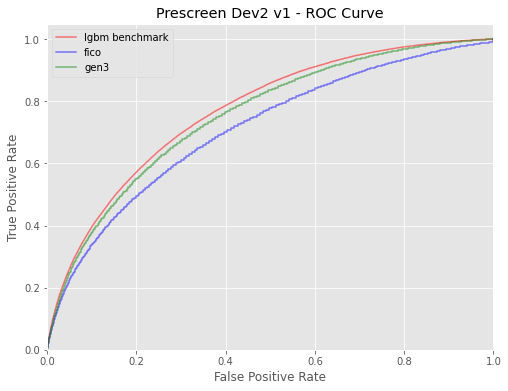

In [24]:
import matplotlib.pyplot as plt
from rdsutils.plot import plot_auc_curve_mult

plt.style.use("ggplot")

y_true = test_df[target]
y_scores = [(test_df["pred_combined_v1_benchmark_mc"], "lgbm benchmark"),
            (test_df["pred_fico"], "fico"),
            (test_df["pred_gen3"], "gen3")]
sample_weight = test_df[weight]

fig, axs = plt.subplots(1, 1, figsize=(8, 6))
plot_auc_curve_mult(y_true, y_scores, sample_weight, colors=["r", "b", "g"], 
                    fill_area=False, alpha=0.5,
                    ax=axs)
axs.set_title("Prescreen combined v1 - ROC Curve")

In [18]:
import shap
from src.utils.governance import get_pdp, get_shap_dependence, pickle_obj
from src.utils.governance import get_feature_by_importance

def save_pdp(model, modeling_df, features, 
             features_plot_order, dir_path, suffix=""):
    
    os.makedirs(dir_path, exist_ok=True)
    fig = get_pdp(modeling_df[features], features, model,
                  features_plot_order, ncols=6)
    fig.savefig(os.path.join(dir_path, f"pdp{suffix}.png"))


def save_shap_dependence(model, modeling_df, features, dir_path, suffix=""):    
    os.makedirs(dir_path, exist_ok=True)
    shap.initjs()
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(modeling_df[model.feature_name_])
    
    pickle_obj(shap_values, os.path.join(dir_path, f"shap_values{suffix}.pkl"))
    
    fig = get_shap_dependence(modeling_df[model.feature_name_], 
                              shap_values[1], features, 
                              interaction_index=None)
    
    fig.savefig(os.path.join(dir_path, f"shap_dependence{suffix}.png"))

with open("./artifacts/models/lightgbm-dev2_v1_benchmark.pkl", "rb") as f:
    lgbm = pkl.load(f)
    
with open("./artifacts/models/lightgbm-dev2_v1_benchmark_mc.pkl", "rb") as f:
    lgbm_mc = pkl.load(f)
    
feature_by_imp = get_feature_by_importance(lgbm)
feature_by_imp_mc = get_feature_by_importance(lgbm_mc)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

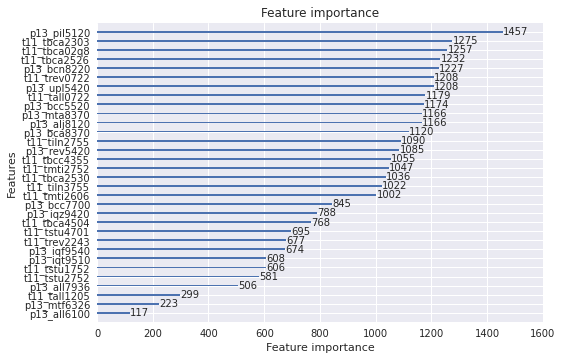

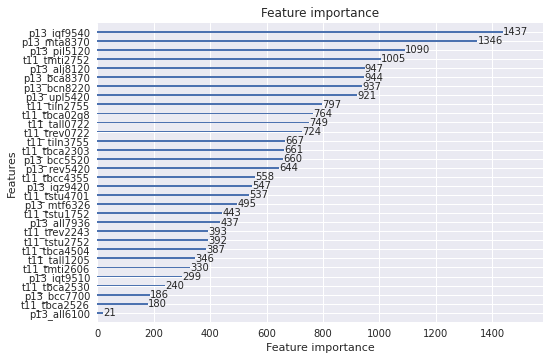

In [21]:
lgb.plot_importance(lgbm.booster_)
lgb.plot_importance(lgbm_mc.booster_)

32it [00:18,  1.77it/s]


CPU times: user 24min 2s, sys: 445 ms, total: 24min 2s
Wall time: 21.7 s


32it [00:12,  2.51it/s]


CPU times: user 19min 13s, sys: 242 ms, total: 19min 14s
Wall time: 15.1 s


CPU times: user 3min 13s, sys: 143 ms, total: 3min 13s
Wall time: 6.09 s


CPU times: user 2min 11s, sys: 150 ms, total: 2min 11s
Wall time: 4.82 s


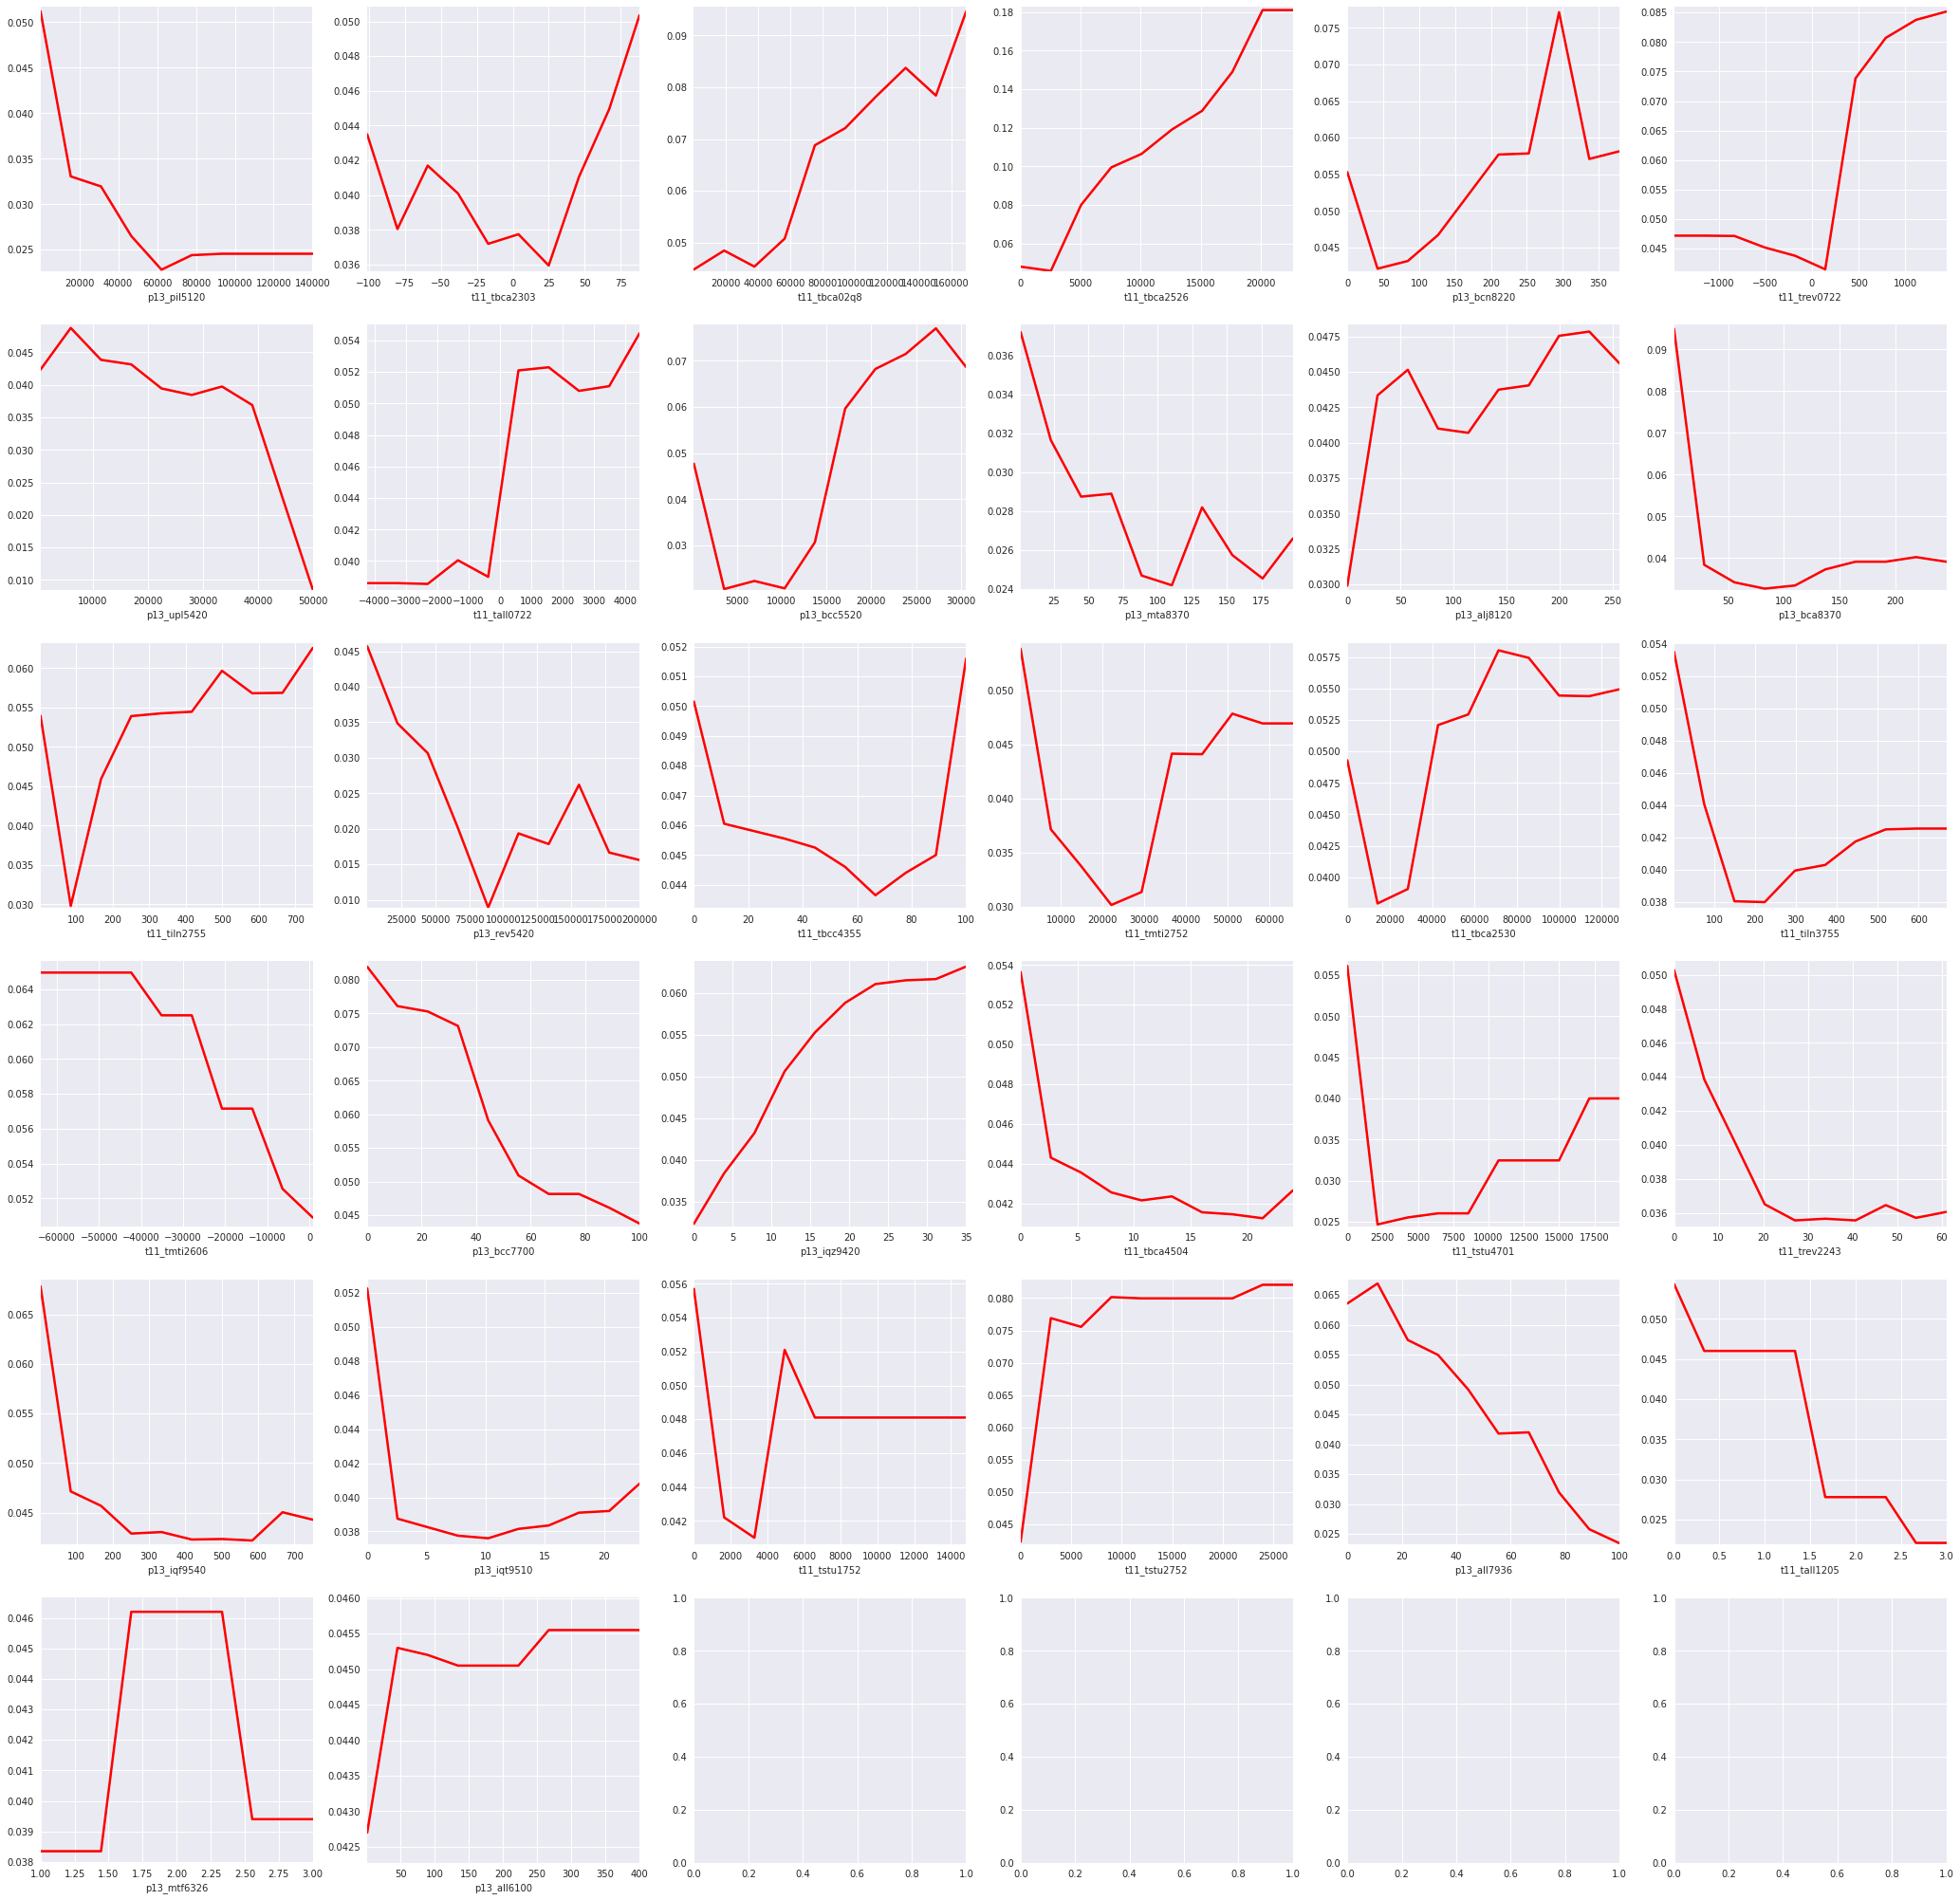

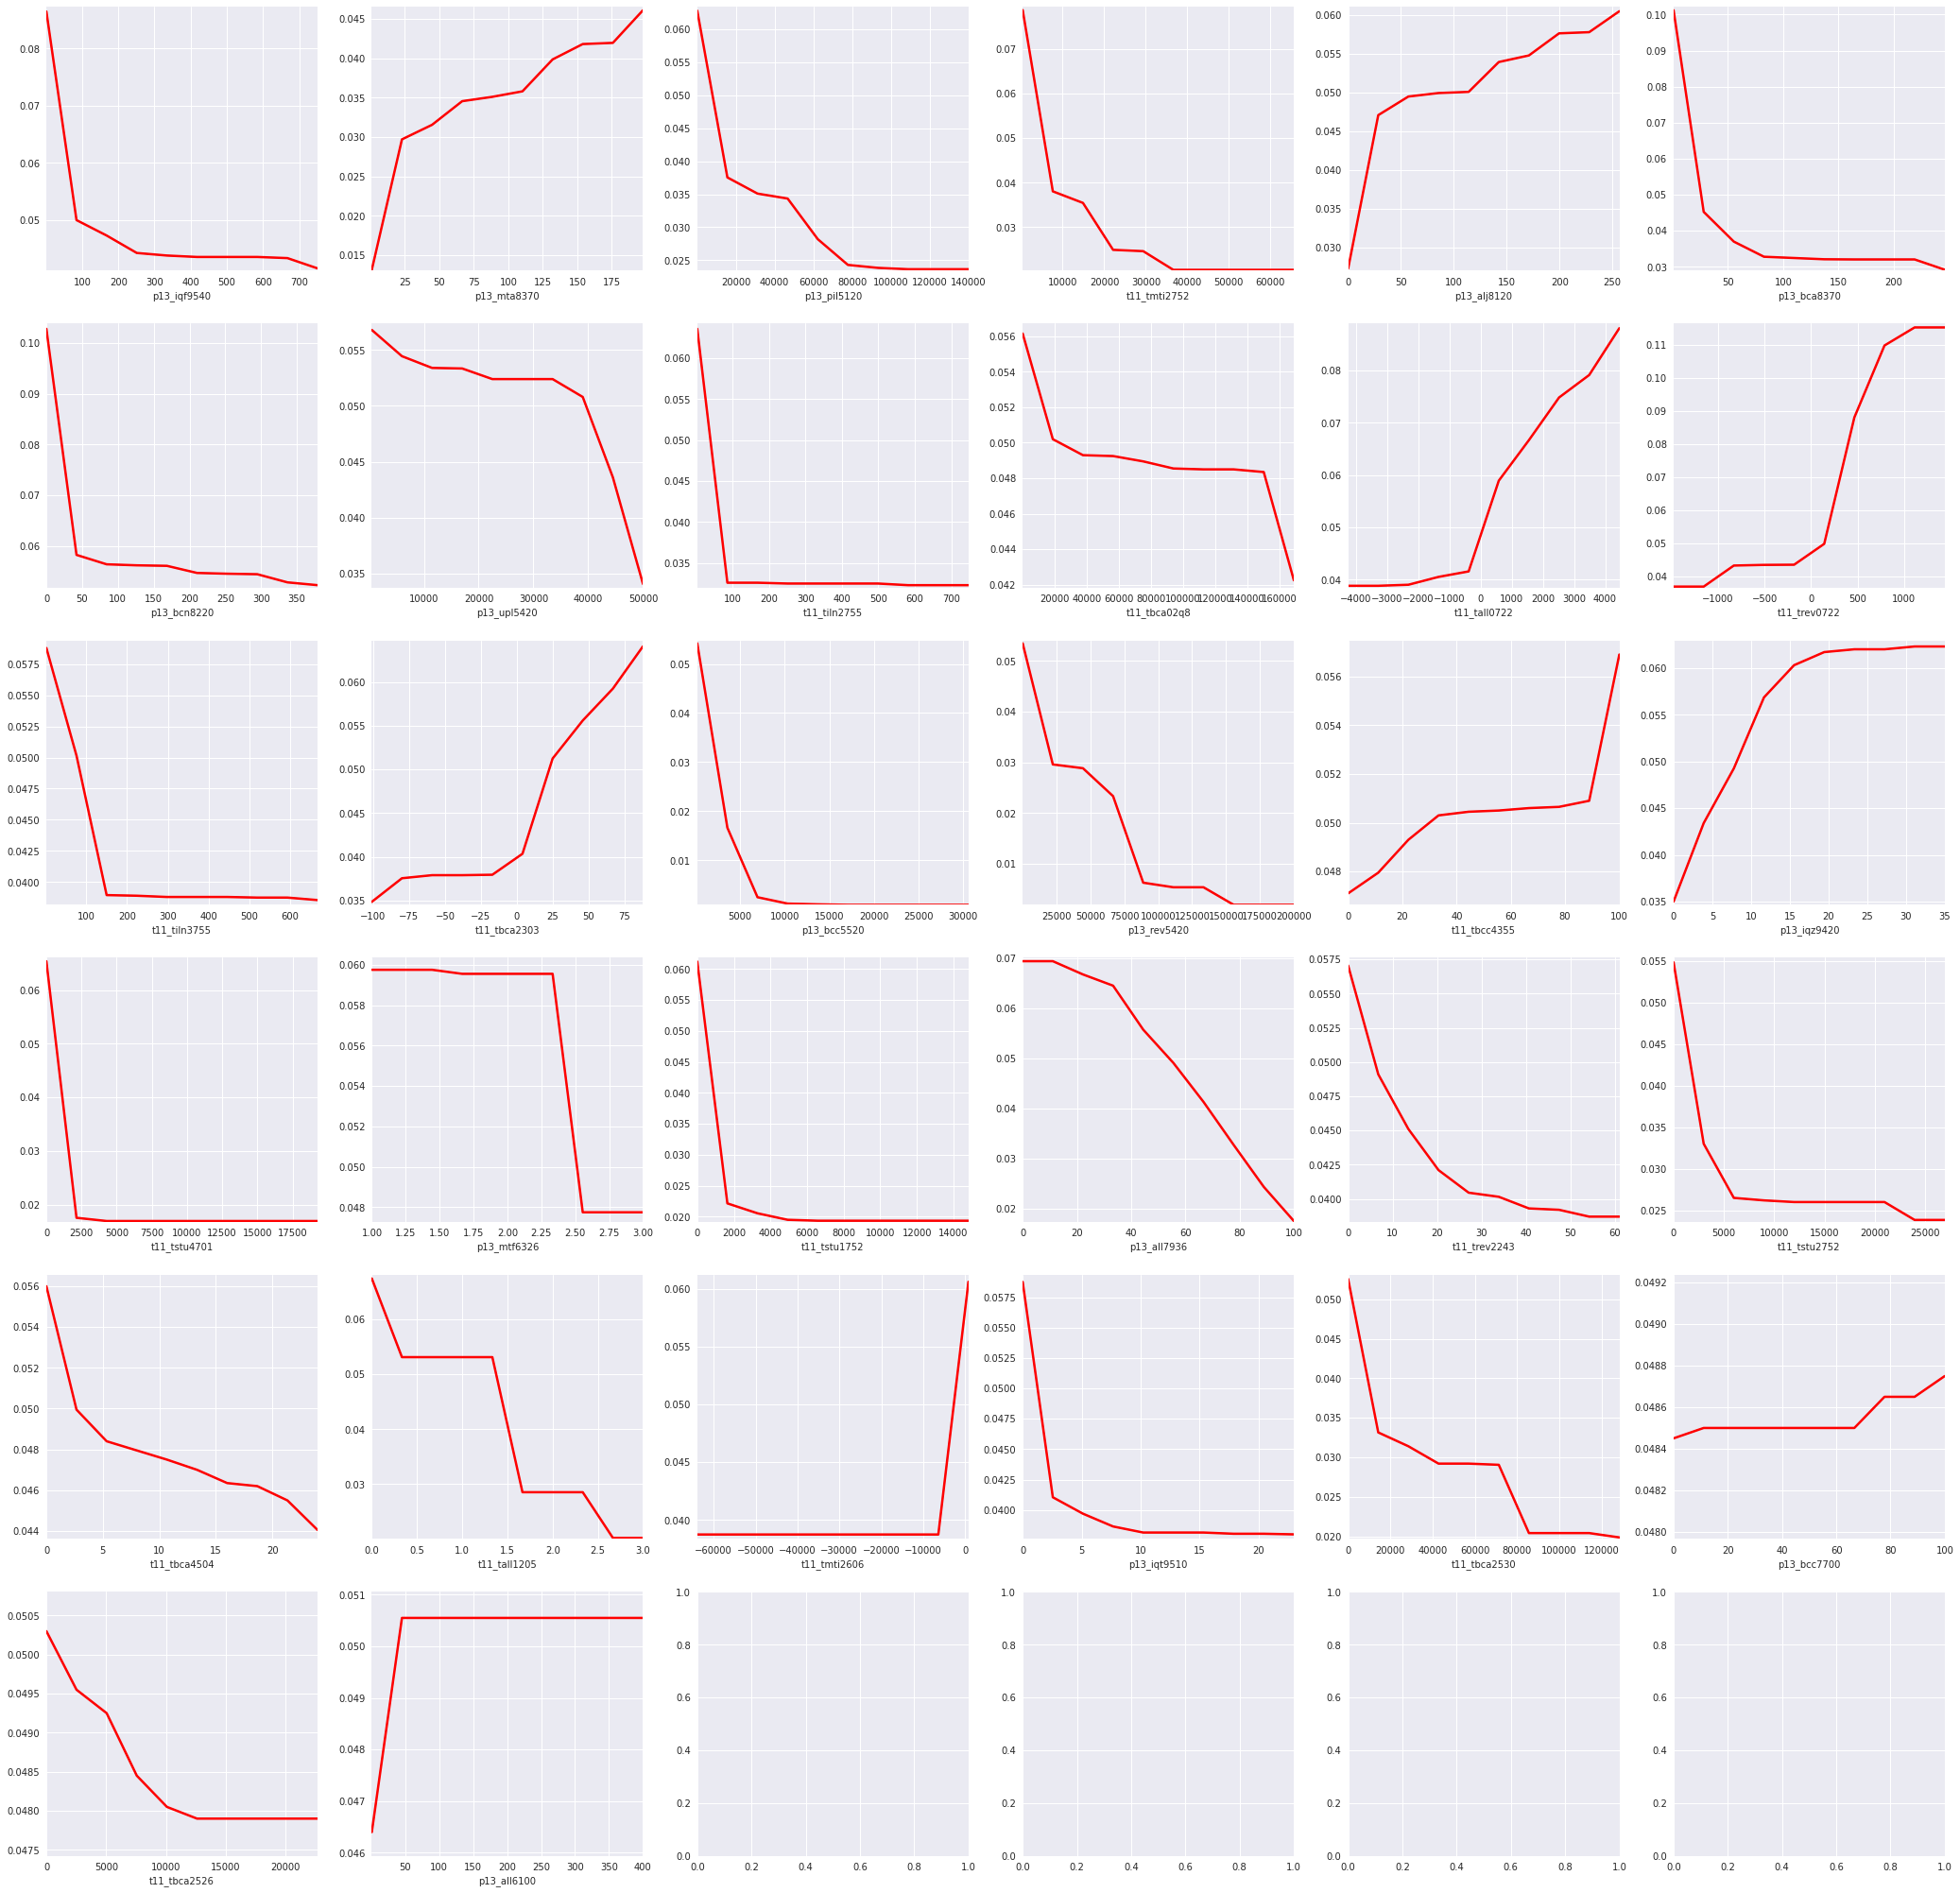

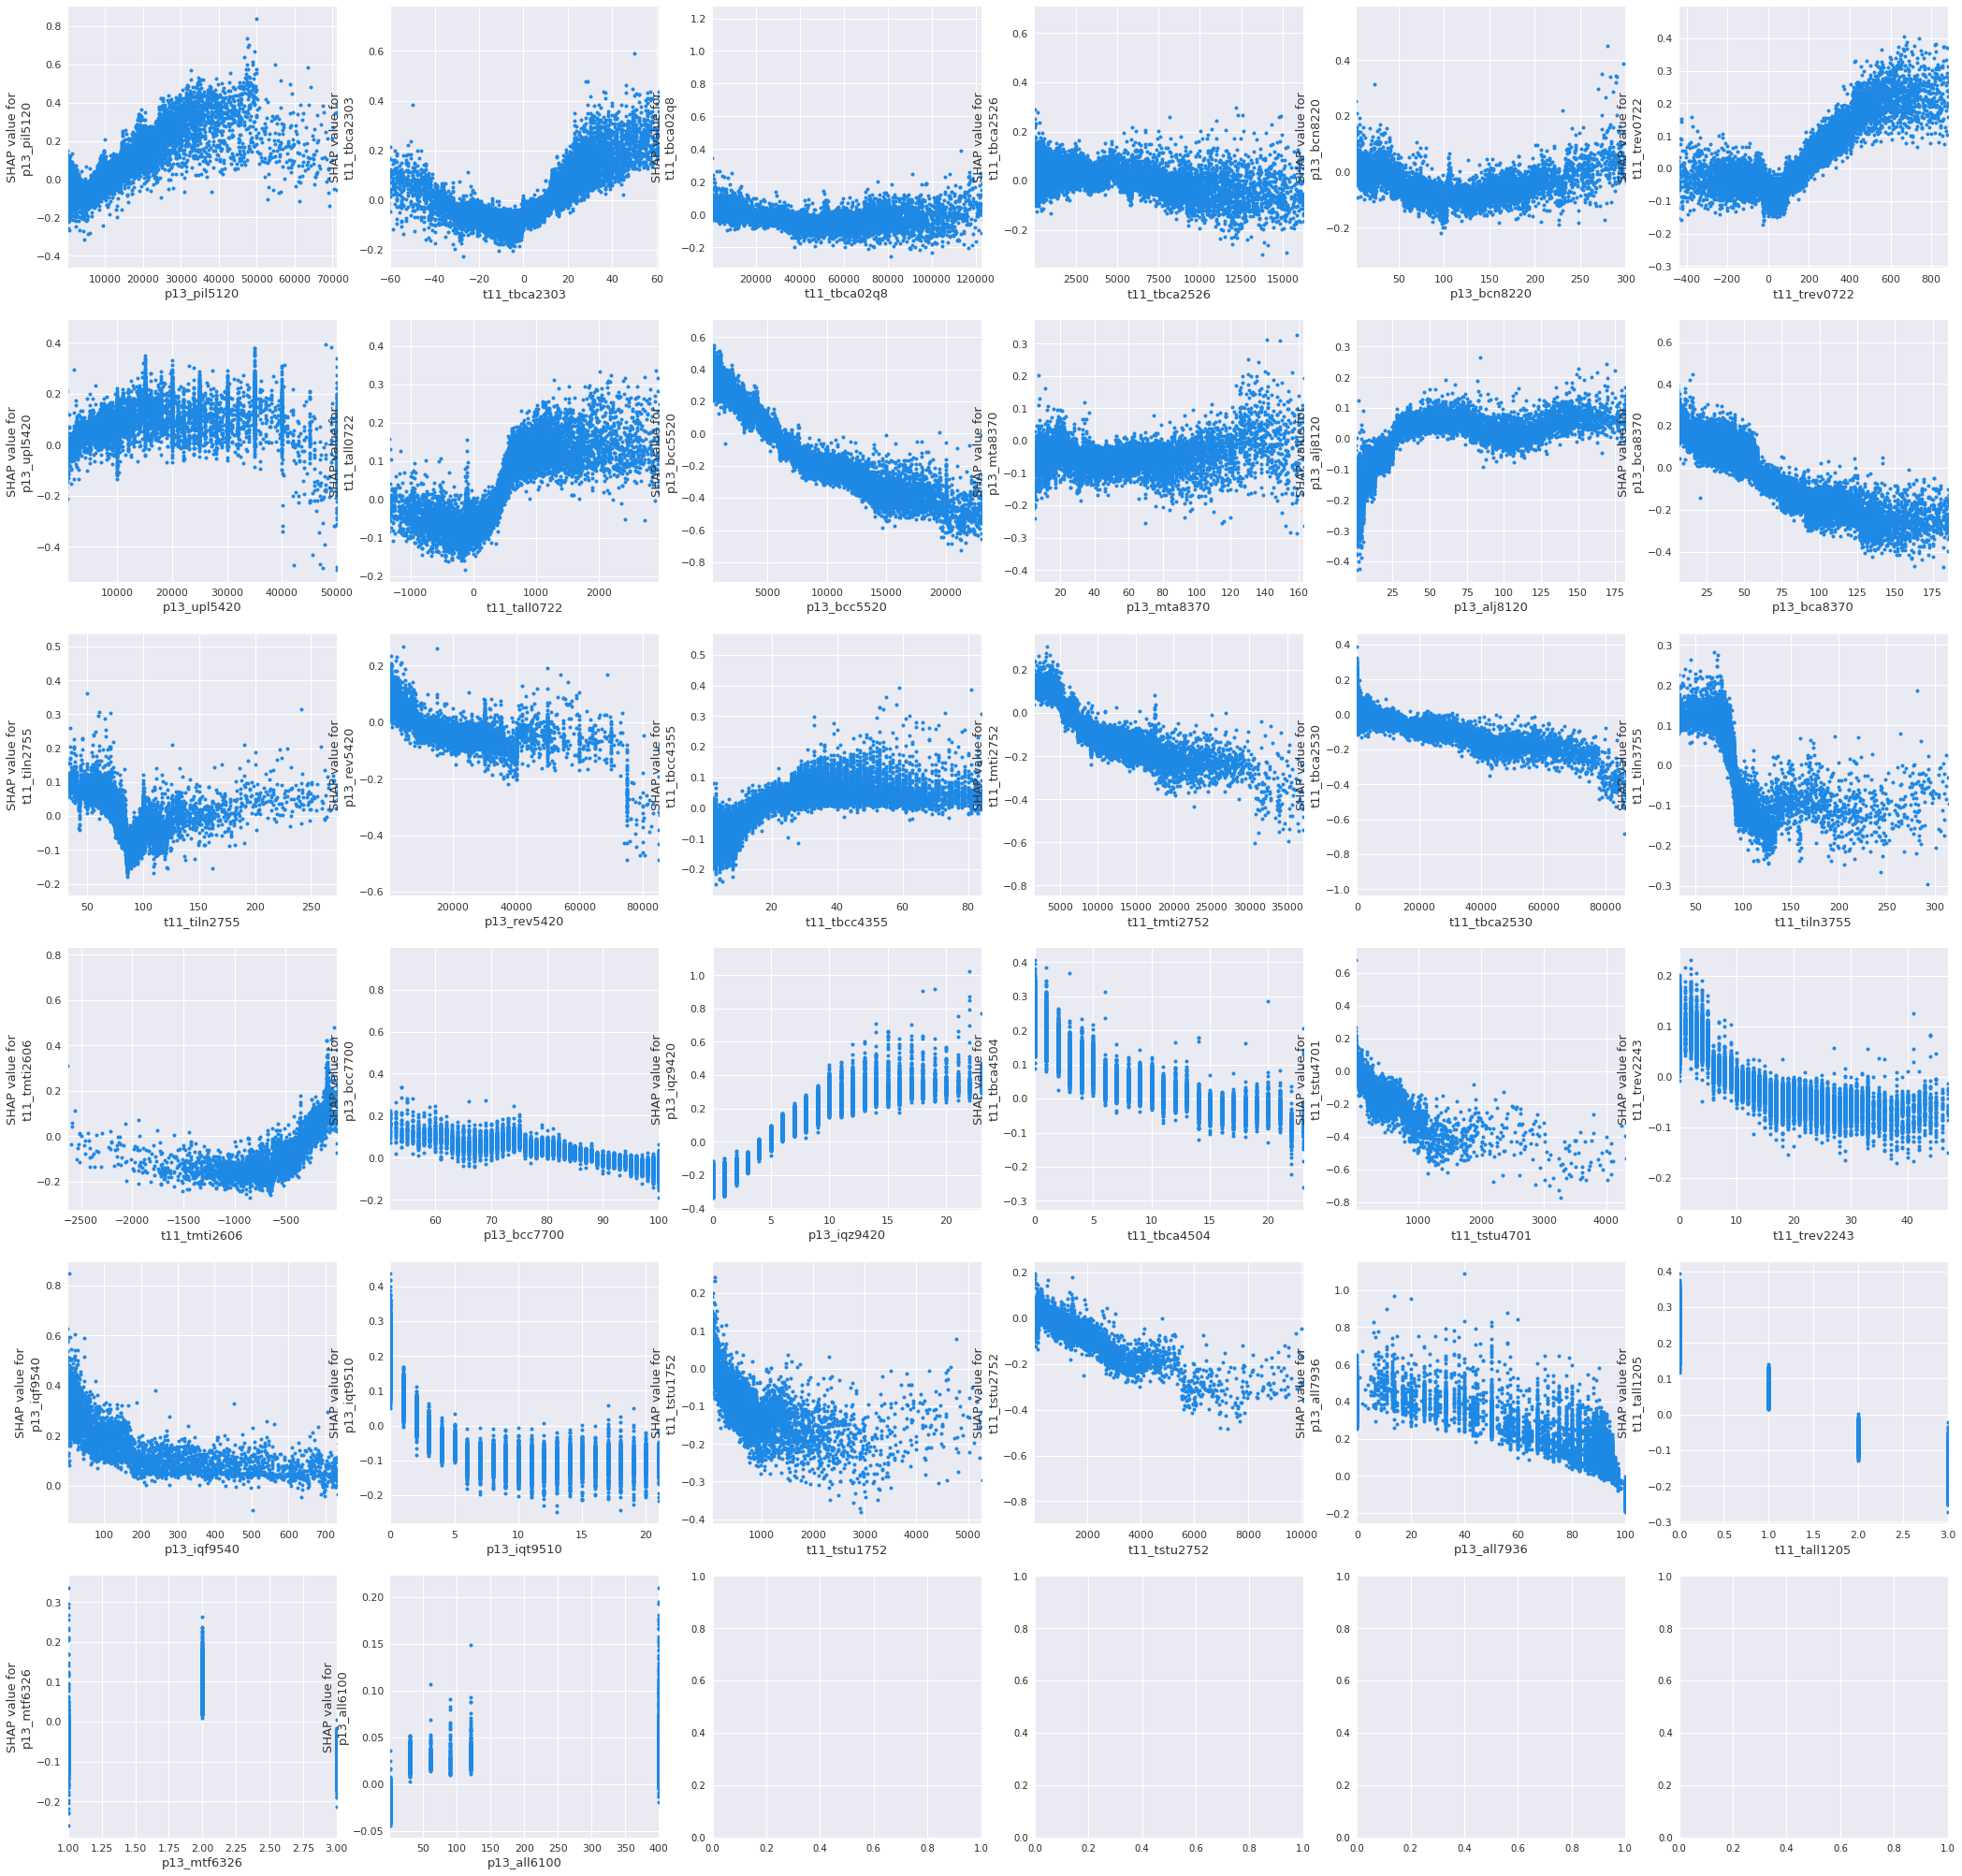

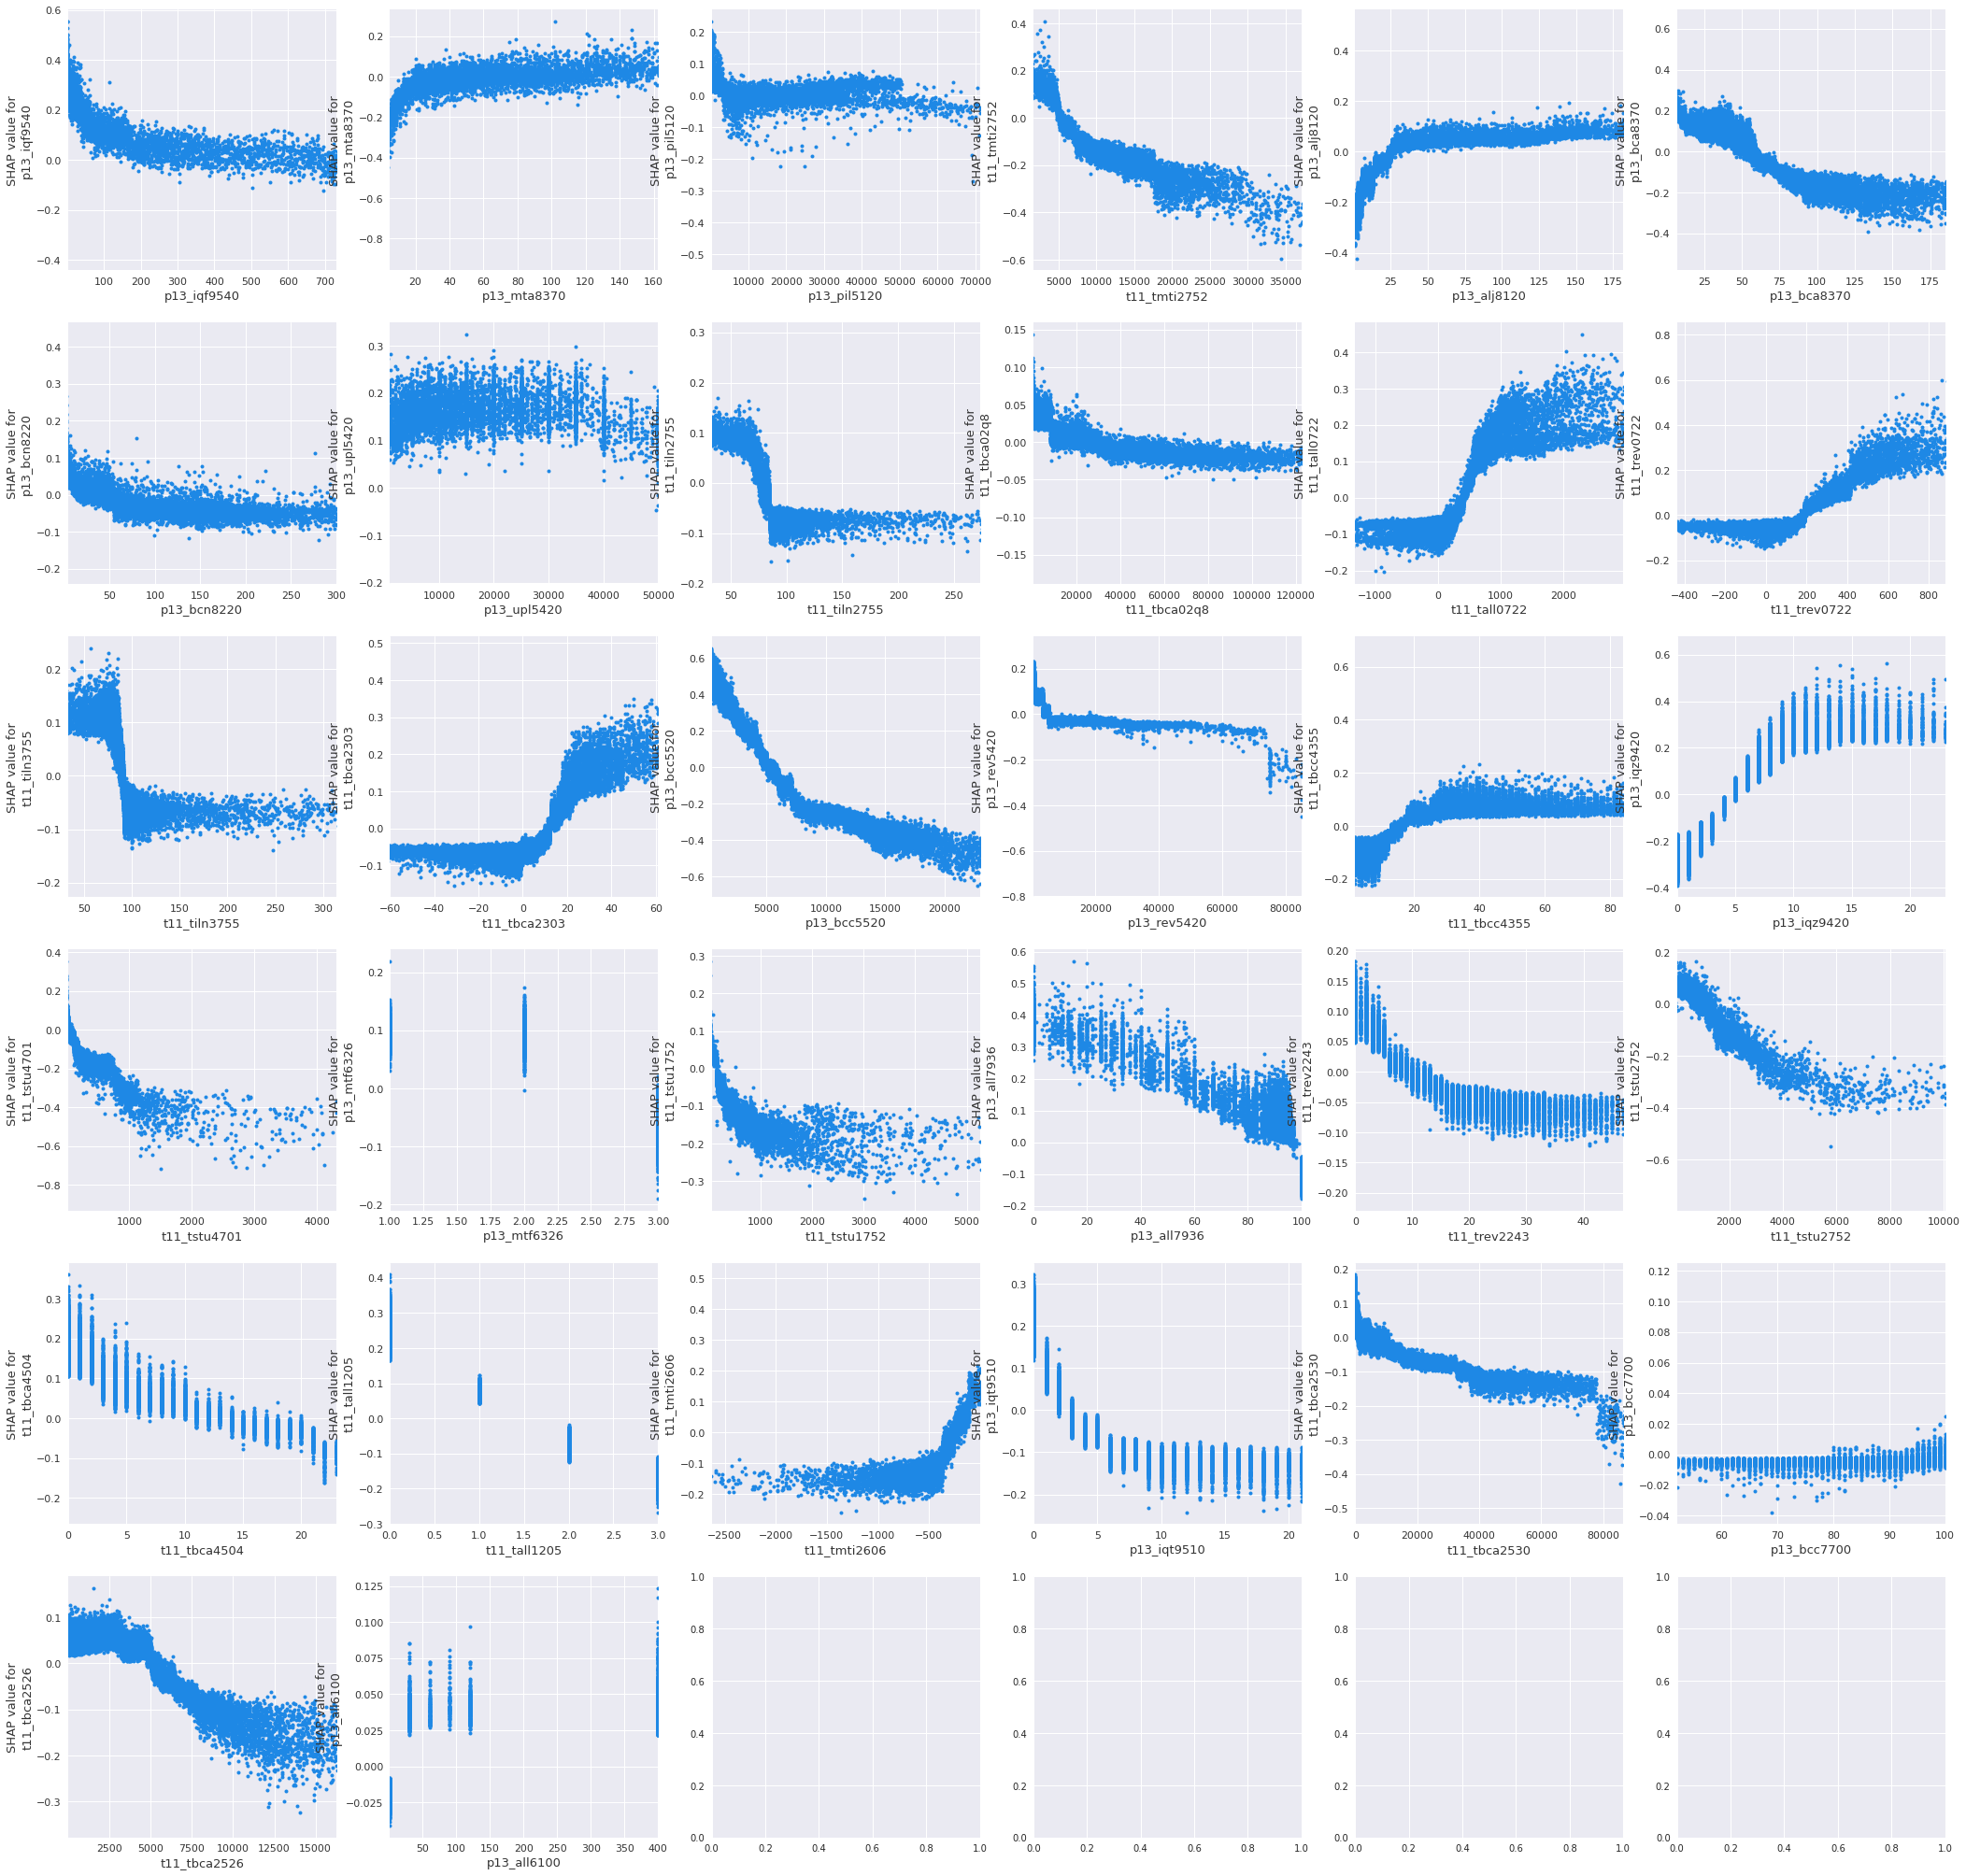

In [23]:
df_ = train_df.sample(n=20000, random_state=seed)
dir_path = "./artifacts/dev2-v1-model-artifacts"

%time save_pdp(lgbm, df_, lgbm.feature_name_, feature_by_imp, dir_path, suffix="")
%time save_pdp(lgbm_mc, df_, lgbm_mc.feature_name_, feature_by_imp_mc, dir_path, suffix="_mc")

%time save_shap_dependence(lgbm, df_, feature_by_imp, dir_path, suffix="")
%time save_shap_dependence(lgbm_mc, df_, feature_by_imp_mc, dir_path, suffix="_mc")

In [40]:
with open("./artifacts/dev2_fsel_v1/woe_dict.pkl", "rb") as f:
    woe_dict = pkl.load(f)

def get_feature_descriptions(features, data_dict):
    dd_cols = ["field_name", "description", "long description", "attr_grp", "categorical", "type"]
    dd = data_dict[dd_cols]
    dd = dd[dd.field_name.isin(lgbm_mc.feature_name_)]
    dd.set_index("field_name", inplace=True)
    return dd.loc[features]

feature_dict = get_feature_descriptions(feature_by_imp_mc, exp_dict)

dir_map = dict(zip(lgbm_mc.feature_name_, lgbm_mc.get_params()["monotone_constraints"]))
feature_dict["dir"] = [dir_map[k] for k in feature_dict.index.values]

display(feature_dict)
feature_dict.to_csv("./artifacts/dev2-v1-model-artifacts/feature_dict.csv")

,description,long description,attr_grp,categorical,type,dir
field_name,,,,,,
p13_iqf9540,IQF9540,Number of days since the most recent personal ...,Public Records/Inquiry,[9999],int,-1
p13_mta8370,MTA8370,Average life span of a mortgage type trade (in...,Age/Recency,"[9999, 9998, 9996, 9994]",int,1
p13_pil5120,PIL5120,Maximum balance on open personal installment t...,Balance Amount Payment,"[999999999, 999999998, 999999997, 999999996]",int,-1
t11_tmti2752,NaN,Total actual payment over the last 6 months on...,Payment magnitude,"[999999999, 999999998, 999999997, 999999996]",int,-1
p13_alj8120,ALJ8120,Number of months since the most recently opene...,Age/Recency,"[9999, 9998, 9996, 9994]",int,1
p13_bca8370,BCA8370,Average life span of a bankcard revolving and ...,Age/Recency,"[9999, 9998, 9996, 9994]",int,-1
p13_bcn8220,BCN8220,Number of months since the oldest no preset sp...,Age/Recency,"[9999, 9998, 9996, 9994]",int,-1
p13_upl5420,UPL5420,Maximum credit amount on open unsecured person...,Balance Amount Payment,"[999999999, 999999998, 999999997, 999999996]",int,-1
t11_tiln2755,NaN,Ratio between total scheduled payment and tota...,Payment variance,"[9999, 9998, 9997, 9996]",int,-1


In [37]:
feature_dict.attr_grp.value_counts()

Age/Recency                          4
Balance Amount Payment               4
Payment magnitude                    4
Payment variance                     4
Public Records/Inquiry               3
Balance to limit ratio variance      2
Rank                                 2
Ratios/Percentage                    2
Balance variance                     2
Available credit amount magnitude    2
Quarterly average                    1
Balance over limit activity          1
Slope                                1
Name: attr_grp, dtype: int64

In [43]:
# many features have significant missing - missing encoding might bring in much value
train_df[lgbm_mc.feature_name_].isna().mean(axis=0).sort_values(ascending=False)

p13_iqf9540     0.828846
t11_tstu1752    0.738034
t11_tstu2752    0.723191
t11_tstu4701    0.677570
p13_upl5420     0.661703
t11_tmti2606    0.598526
p13_pil5120     0.579284
p13_mtf6326     0.562793
t11_tmti2752    0.560868
p13_mta8370     0.481255
t11_tbca4504    0.479699
p13_bcn8220     0.442314
p13_alj8120     0.293606
t11_tiln2755    0.174830
t11_tiln3755    0.156543
t11_tbca02q8    0.131619
t11_trev0722    0.092782
t11_tbca2303    0.091807
p13_bcc5520     0.078623
p13_bcc7700     0.078622
p13_iqt9510     0.065236
t11_tbca2530    0.060311
t11_tbca2526    0.060303
t11_tbcc4355    0.054397
p13_rev5420     0.053468
t11_trev2243    0.046453
t11_tall0722    0.041275
p13_bca8370     0.031587
t11_tall1205    0.014987
p13_all7936     0.001526
p13_all6100     0.000105
p13_iqz9420     0.000000
dtype: float64